# Predicción de Default de Clientes con Regresión Logística
En este cuaderno desarrolla un modelo de clasificación para predecir si un cliente incurrirá en default el próximo mes. El dataset incluye 23 variables relacionadas con historial crediticio, pagos y características demográficas.

In [1]:
import os
import pandas as pd
import gzip
import json
import pickle

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import  SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score
print("All necessary libraries imported successfully.")

All necessary libraries imported successfully.


# Paso 1.
- Realice la limpieza de los datasets:
- Renombre la columna "default payment next month" a "default".
- Remueva la columna "ID".
- Elimine los registros con informacion no disponible.
- Para la columna EDUCATION, valores > 4 indican niveles superiores de educación, agrupe estos valores en la categoría "others".
- Renombre la columna "default payment next month" a "default"
- Remueva la columna "ID".

In [2]:
train_data = pd.read_csv("../files/input/train_data.csv.zip")
test_data = pd.read_csv("../files/input/test_data.csv.zip")

train_data.rename(columns={"default payment next month": "default"}, inplace=True)
test_data.rename(columns={"default payment next month": "default"}, inplace=True)

train_data.drop(columns=["ID"], inplace=True)
test_data.drop(columns=["ID"], inplace=True)

train_data = train_data[(train_data["MARRIAGE"] != 0) & (train_data["EDUCATION"] != 0)]
test_data = test_data[(test_data["MARRIAGE"] != 0) & (test_data["EDUCATION"] != 0)]

train_data["EDUCATION"] = train_data["EDUCATION"].clip(upper=4)
test_data["EDUCATION"] = test_data["EDUCATION"].clip(upper=4)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

print("Data cleaning completed successfully.")


Data cleaning completed successfully.


# Paso 2.
- Divida los datasets en x_train, y_train, x_test, y_test.

In [3]:
x_train = train_data.drop(columns=["default"])
y_train = train_data["default"]

x_test = test_data.drop(columns=["default"])
y_test = test_data["default"]
print("Datasets divided into x_train, y_train, x_test, y_test successfully.")

Datasets divided into x_train, y_train, x_test, y_test successfully.


# Paso 3.
Cree un pipeline para el modelo de clasificación. Este pipeline debe contener las siguientes capas:

- Transforma las variables categoricas usando el método one-hot-encoding.
- Descompone la matriz de entrada usando PCA. El PCA usa todas las componentes.
- Estandariza la matriz de entrada.
- Selecciona las K columnas mas relevantes de la matrix de entrada.
- Ajusta una maquina de vectores de soporte (svm).

# Paso 4.
- Optimice los hiperparametros del pipeline usando validación cruzada.
- Use 10 splits para la validación cruzada. Use la función de precision balanceada para medir la precisión del modelo.

In [4]:
categorical = ["SEX", "EDUCATION", "MARRIAGE"]
numerical = list(set(x_train.columns) - set(categorical))

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaler", StandardScaler(), numerical),
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA()),
    ("kbest", SelectKBest(f_classif)),
    ("svc", SVC(random_state=12345))
])
print("Pipeline created successfully.")

Pipeline created successfully.


In [5]:
param_grid = {
    "pca__n_components": [20, x_train.shape[1] - 2],
    "kbest__k": [12],
    "svc__gamma": [0.1]
}

model = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring="balanced_accuracy"
)

model.fit(x_train, y_train)
print("Model training and hyperparameter optimization completed successfully.")

Model training and hyperparameter optimization completed successfully.


# Paso 5.
- Guarde el modelo (comprimido con gzip) como "files/models/model.pkl.gz".
- Recuerde que es posible guardar el modelo comprimido usanzo la libreria gzip.

In [6]:
os.makedirs("../files/models", exist_ok=True)

with gzip.open("../files/models/model.pkl.gz", "wb") as f:
    pickle.dump(model, f)
print("Model saved successfully as 'model.pkl.gz'.")

Model saved successfully as 'model.pkl.gz'.


# Paso 6.
- Calcule las metricas de precision, precision balanceada, recall, y f1-score para los conjuntos de entrenamiento y prueba.
- Guardelas en el archivo files/output/metrics.json. Cada fila del archivo es un diccionario con las metricas de un modelo.
### Este diccionario tiene un campo para indicar si es el conjunto de entrenamiento o prueba. Por ejemplo:
- {'dataset': 'train', 'precision': 0.8, 'balanced_accuracy': 0.7, 'recall': 0.9, 'f1_score': 0.85}
- {'dataset': 'test', 'precision': 0.7, 'balanced_accuracy': 0.6, 'recall': 0.8, 'f1_score': 0.75}

# Paso 7.
- Calcule las matrices de confusion para los conjuntos de entrenamiento y
- prueba. Guardelas en el archivo files/output/metrics.json. Cada fila  del archivo es un diccionario con las metricas de un modelo. de entrenamiento o prueba. Por ejemplo:

- - {'type': 'cm_matrix', 'dataset': 'train', 'true_0': {"predicted_0": 15562, "predicte_1": 666}, 'true_1': {"predicted_0": 3333, "predicted_1": 1444}}
- - {'type': 'cm_matrix', 'dataset': 'test', 'true_0': {"predicted_0": 15562, "predicte_1": 650}, 'true_1': {"predicted_0": 2490, "predicted_1": 1420}}
#


In [7]:
metrics = []

# 1. Primero MÉTRICAS train y test
for x, y, label in [(x_train, y_train, "train"), (x_test, y_test, "test")]:
    pred = model.predict(x)
    metrics.append({
        "type": "metrics",
        "dataset": label,
        "precision": precision_score(y, pred),
        "balanced_accuracy": balanced_accuracy_score(y, pred),
        "recall": recall_score(y, pred),
        "f1_score": f1_score(y, pred)
    })

# 2. Luego CM train y test
for x, y, label in [(x_train, y_train, "train"), (x_test, y_test, "test")]:
    pred = model.predict(x)
    cm = confusion_matrix(y, pred)

    metrics.append({
        "type": "cm_matrix",
        "dataset": label,
        "true_0": {
            "predicted_0": int(cm[0,0]),
            "predicted_1": int(cm[0,1])
        },
        "true_1": {
            "predicted_0": int(cm[1,0]),
            "predicted_1": int(cm[1,1])
        }
    })
print("Metrics calculated successfully.")

Metrics calculated successfully.


In [8]:
os.makedirs("../files/output", exist_ok=True)

with open("../files/output/metrics.json", "w", encoding="utf-8") as f:
    for m in metrics:
        f.write(json.dumps(m, ensure_ascii=False) + "\n")
print("Metrics calculated and saved successfully to 'metrics.json'.")

Metrics calculated and saved successfully to 'metrics.json'.


Lo siguiente no es necesario para el test, 

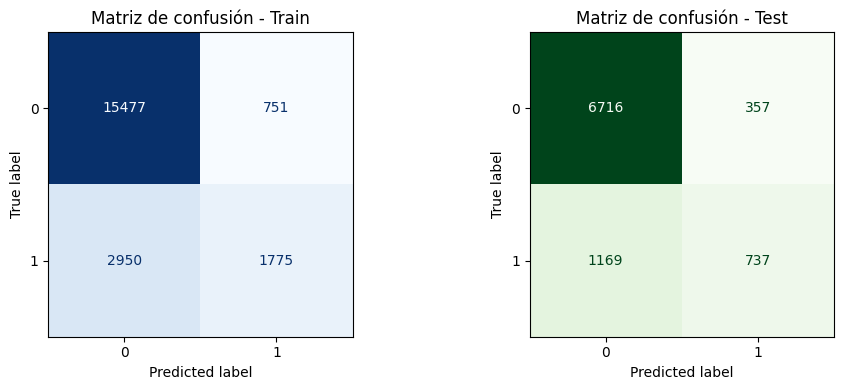

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Predicciones
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de confusión - TRAIN
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    ax=axes[0],
    cmap="Blues",
    colorbar=False
)
axes[0].set_title("Matriz de confusión - Train")

# Matriz de confusión - TEST
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    ax=axes[1],
    cmap="Greens",
    colorbar=False
)
axes[1].set_title("Matriz de confusión - Test")

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Confusion matrix - TRAIN")
print(cm_train)
print("\nConfusion matrix - TEST")
print(cm_test)


Confusion matrix - TRAIN
[[15477   751]
 [ 2950  1775]]

Confusion matrix - TEST
[[6716  357]
 [1169  737]]
